In [1]:
#import warnings
#warnings.filterwarnings("ignore")
import logging
logging.getLogger('tensorflow').disabled = True

import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4)

plt.style.use("seaborn-colorblind")
plt.rcParams["figure.figsize"] = (8, 6)
sns.set_style("darkgrid")
#sns.set_context("talk")
sns.set_context(context='notebook', font_scale=1.25)
sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

# NOTE: It is important that you set a seed value to get same results in every run.
# Any number is Ok.
seed = 817#123
random.seed(seed)
np.random.seed(seed)

#class_names = ['Ellipse','4lateral','3angle']
class_names = ['0','4','3']
num_channels, KERNEL_SIZE, alpha = 1, (9,9), 0.0003
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SHAPE, num_classes = 40, 40, (40,40,num_channels), len(class_names)
# training parameters
NUM_EPOCHS, BATCH_SIZE = 15, 128
# for loading & saving model state
KR_MODEL_NAME = 'keras_shapes.h5'

Using TensorFlow backend.


In [2]:
def edge_detection(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_red = np.array([30,150,50])
    upper_red = np.array([255,255,180])

    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(frame,frame, mask= mask)

    return cv2.Canny(frame,70,120)

In [3]:
def load_and_preprocess_data(debug=False, edgeDetect=False, folder='Fill2NoBg'):
    from keras.utils import to_categorical
    
    # loading data
    PATH = os.getcwd()
    # Define data path
    data_path = PATH + '/../ShapeData/' + folder
    data_dir_list = os.listdir(data_path)

    img_data_list=[]

    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            if edgeDetect:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,1)
                img_data_list.append(edge_detection(input_img))
            else:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)#1=RGB,0=Grey,-1=unchanged
                img_data_list.append(input_img)
#            input_img_resize=cv2.resize(input_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
#            img_data_list.append(input_img_resize)
#             img_data_list.append(edge_detection(input_img))
    
    X_train = np.array(img_data_list)
    num_data = X_train.shape[0]
    
    # Assigning Labels
    y_train = np.ones((num_data,),dtype='int64')
    for i in range(0,num_classes):
        y_train[int(np.floor((i)*num_data/num_classes)):int(np.floor((i+1)*num_data/num_classes))]=i
    
    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))

    #shuffle data
    indexes = np.random.permutation(X_train.shape[0])
    X_train, y_train = X_train[indexes], y_train[indexes]
    
    #split data into 3 parts & keep copy of test images and labels
    num_train=int(np.floor(num_data*0.8))
    num_cross=int(np.floor(num_train*0.2))
    
    X_val, y_val = X_train[num_train:num_train+num_cross], y_train[num_train:num_train+num_cross]
    X_test, y_test = X_train[num_train+num_cross:], y_train[num_train+num_cross:]
    test_images, test_labels = X_test.copy(), y_test.copy()
    X_train, y_train = X_train[:num_train], y_train[:num_train]
    
    #scale images and one-hot encode labels(from 0 to [1,0,0] ,1 to [0,1,0] etc)
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, num_classes) 
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    #Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], num_channels))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], num_channels))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], num_channels))
    
    if debug:
        print('After preprocessing: ')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(
            test_images.shape, test_labels.shape))  
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [4]:
def display_sample(sample_images, sample_labels, sample_predictions=None,
                   num_rows=5, num_cols=10, plot_title=None, fig_size=None):
    """ 
    display a random selection of images & corresponding labels, optionally with predictions 
    The display is laid out in a grid of num_rows x num_col cells.
    If sample_predictions are provided, then each cell's title displays the prediction (if it 
    matches actual value) else it displays actual value/prediction. 
    """
    assert sample_images.shape[0] == num_rows * num_cols
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows,num_cols,figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index] 
                                ,cmap="gray" #cmap grey so the image is black and white, not 2 random colours
                                ,vmin=0,vmax=255 #vmin and vmax is needed otherwise the image will be two tone
                                )

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title(class_names[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = class_names[sample_labels[image_index]]
                    pred_label = class_names[sample_predictions[image_index]]
                    prediction_matches_true = \
                        (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = true_label
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        #title = 'Num: %s/%s' % (true_label, pred_label)
                        title = pred_label +'/'+ true_label
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None: f.suptitle(plot_title)
    
        plt.show()
        plt.close()

In [9]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels) = \
    load_and_preprocess_data(edgeDetect=True)

Loaded the images of dataset-Ellipse

Loaded the images of dataset-Quadrilateral

Loaded the images of dataset-Triangle



### Making Predictions with the Keras Model
Next we will run predictions with our Tensorflow model & view some random results.

# Loading model

In [6]:
import tensorflow as tf

# load model
kr_model = tf.compat.v1.keras.models.load_model(KR_MODEL_NAME)
# summarize model.
kr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

In [10]:
predictions = kr_model.predict(X_test)
# reverse one-hot encode the predictions
y_pred = np.argmax(predictions, axis=1)
# reverse one-hot encode of test data (this is the ground truth)
y_true = np.argmax(y_test, axis=1)
#y_pred[:30]
# count of predictions & how many incorrect predictions overall??
len(y_pred), (y_pred != y_true).sum()

(2400, 133)

Displaying a sample of 50 mistaken images from dataset


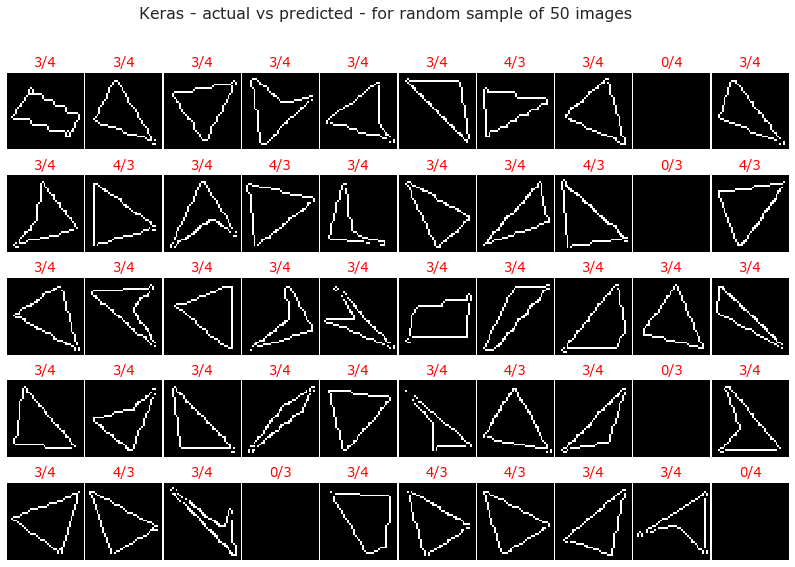

In [11]:
# NOTE: the title of each cell shows the predicted value in green if prediction matches actual
# else cell title shows actual/predicted value in red font
sample_size = 50
print('Displaying a sample of {} mistaken images from dataset'.format(sample_size))
indexes = np.where(y_pred != y_true)[0].astype('int32')[:sample_size]
sample_images, sample_labels, sample_predictions = test_images[indexes], test_labels[indexes], y_pred[indexes]
display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
               num_rows=5, num_cols=10, 
               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))

# User Interface

In [8]:
import tkinter
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

window = tkinter.Tk()
window.geometry('200x200')
window.configure(background = 'PeachPuff3')

def predict_img():
    img_data_list=[]
    input_img=cv2.imread(window.filename,0)
    input_img_resize=cv2.resize(input_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    img_data_list.append(input_img_resize)
    X_input = np.array(img_data_list)
    num_data = X_input.shape[0]
    X_input = X_input.astype('float32') / 255.0
    X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], X_input.shape[2], num_channels))
    predictions = kr_model.predict(X_input)
    y_pred = np.argmax(predictions, axis=1)
    lbl.config(text = class_names[y_pred[0]])
    
def ask_for_file():
    window.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",
                                            filetypes = (("jpeg files","*.jpg;*.png"),("all files","*.*")))
    if window.filename != '':
        img = ImageTk.PhotoImage(Image.open(window.filename))
        panel = Label(window, image = img)
        panel.pack(side = "bottom")#, fill = "both", expand = "yes")
        predict_img()
        window.mainloop()

btn = tkinter.Button(window, text = 'Add Test Image', command = ask_for_file)
btn.pack()


lbl = tkinter.Label(window, text = 'Nothing yet!')
lbl.pack(fill=X)

def predict_image():
    input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img,0)
window.mainloop()

In [9]:
kr_model.summary()
#kr_model.layers[0].get_weights()
# summarize filter shapes
for layer in kr_model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        5248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1

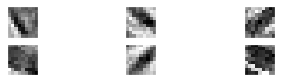

In [10]:
import matplotlib.pyplot as pyplot
model = kr_model
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, 0], cmap='gray')
        ix += 1
# show the figure
pyplot.show()
#display_sample(sample_images, sample_labels, sample_predictions=sample_predictions, 
#               num_rows=5, num_cols=10, 
#               plot_title="Keras - actual vs predicted - for random sample of {} images".format(sample_size))